# CS 4661: Introduction to Data Science
## Final Project
### Title: Amazon employees access predictionThe Amazon Employee Access Challenge aims to predict employee access requirements for different resources within Amazon's internal network. Given historical data about employees and the resources they accessed, the project focuses on building a machine learning model that can efficiently and accurately predict future access needs, improving security and resource management by minimizing unnecessary permissions.

#### Team member:
Jaydeep Dhirubhai Gondaliya\
Nikhil Dhiman\
Kinnariben Manojkumar Kotadiya\
Dhruvi Shaileshbhai Desai\
Drashti Shah

In [446]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, make_scorer, roc_auc_score
from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [447]:
# Loading Data from from local system
data = pd.read_csv(r"C:\Users\ndhiman\Downloads\amazon-employee-access-challenge 2\amazon-employee-access-challenge\train.csv")
data_test = pd.read_csv(r"C:\Users\ndhiman\Downloads\amazon-employee-access-challenge 2\amazon-employee-access-challenge\test.csv")

### Exploring Data

In [449]:
data.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')

In [450]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [451]:
data.isna().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [452]:
data.isna().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [453]:
data.nunique(axis=0)

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [454]:
data['ACTION'].value_counts()

ACTION
1    30872
0     1897
Name: count, dtype: int64

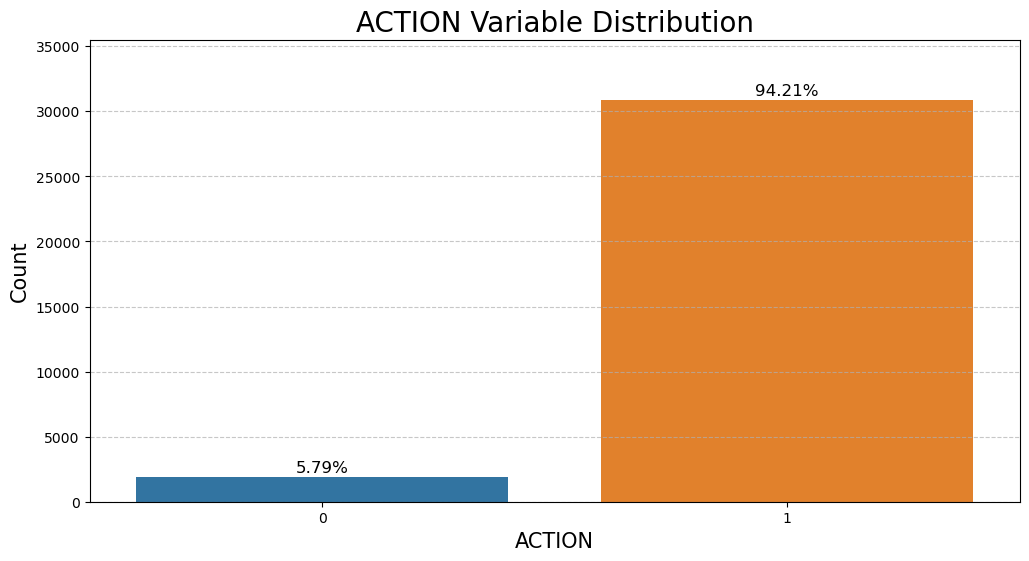

In [455]:
# Calculate the total number of observations
total_observations = len(data)

# Set up the figure size
plt.figure(figsize=(12, 6))

target_plot = sns.countplot(x='ACTION', data=data, palette=['#1f77b4', '#ff7f0e'])  # Specify custom colors

# Set plot title and axis labels
target_plot.set_title("ACTION Variable Distribution", fontsize=20)
target_plot.set_xlabel("ACTION", fontsize=15)
target_plot.set_ylabel("Count", fontsize=15)

# Annotate bars with percentages
bar_counts = [bar.get_height() for bar in target_plot.patches]  # Get heights of all bars
for bar, count in zip(target_plot.patches, bar_counts):
    target_plot.text(
        x=bar.get_x() + bar.get_width() / 2, 
        y=count + total_observations * 0.01,  # Adjusted for spacing
        s=f'{count / total_observations * 100:.2f}%', 
        ha='center', 
        fontsize=12
    )

target_plot.set_ylim(0, max(bar_counts) * 1.15)
target_plot.yaxis.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


This graph illustrates the distribution of the target variable ACTION, showcasing a significant imbalance between the two classes. Approximately 94.21% of the observations fall into class 1, while only 5.79% belong to class 0. This imbalance highlights the dominance of class 1 in the dataset. 

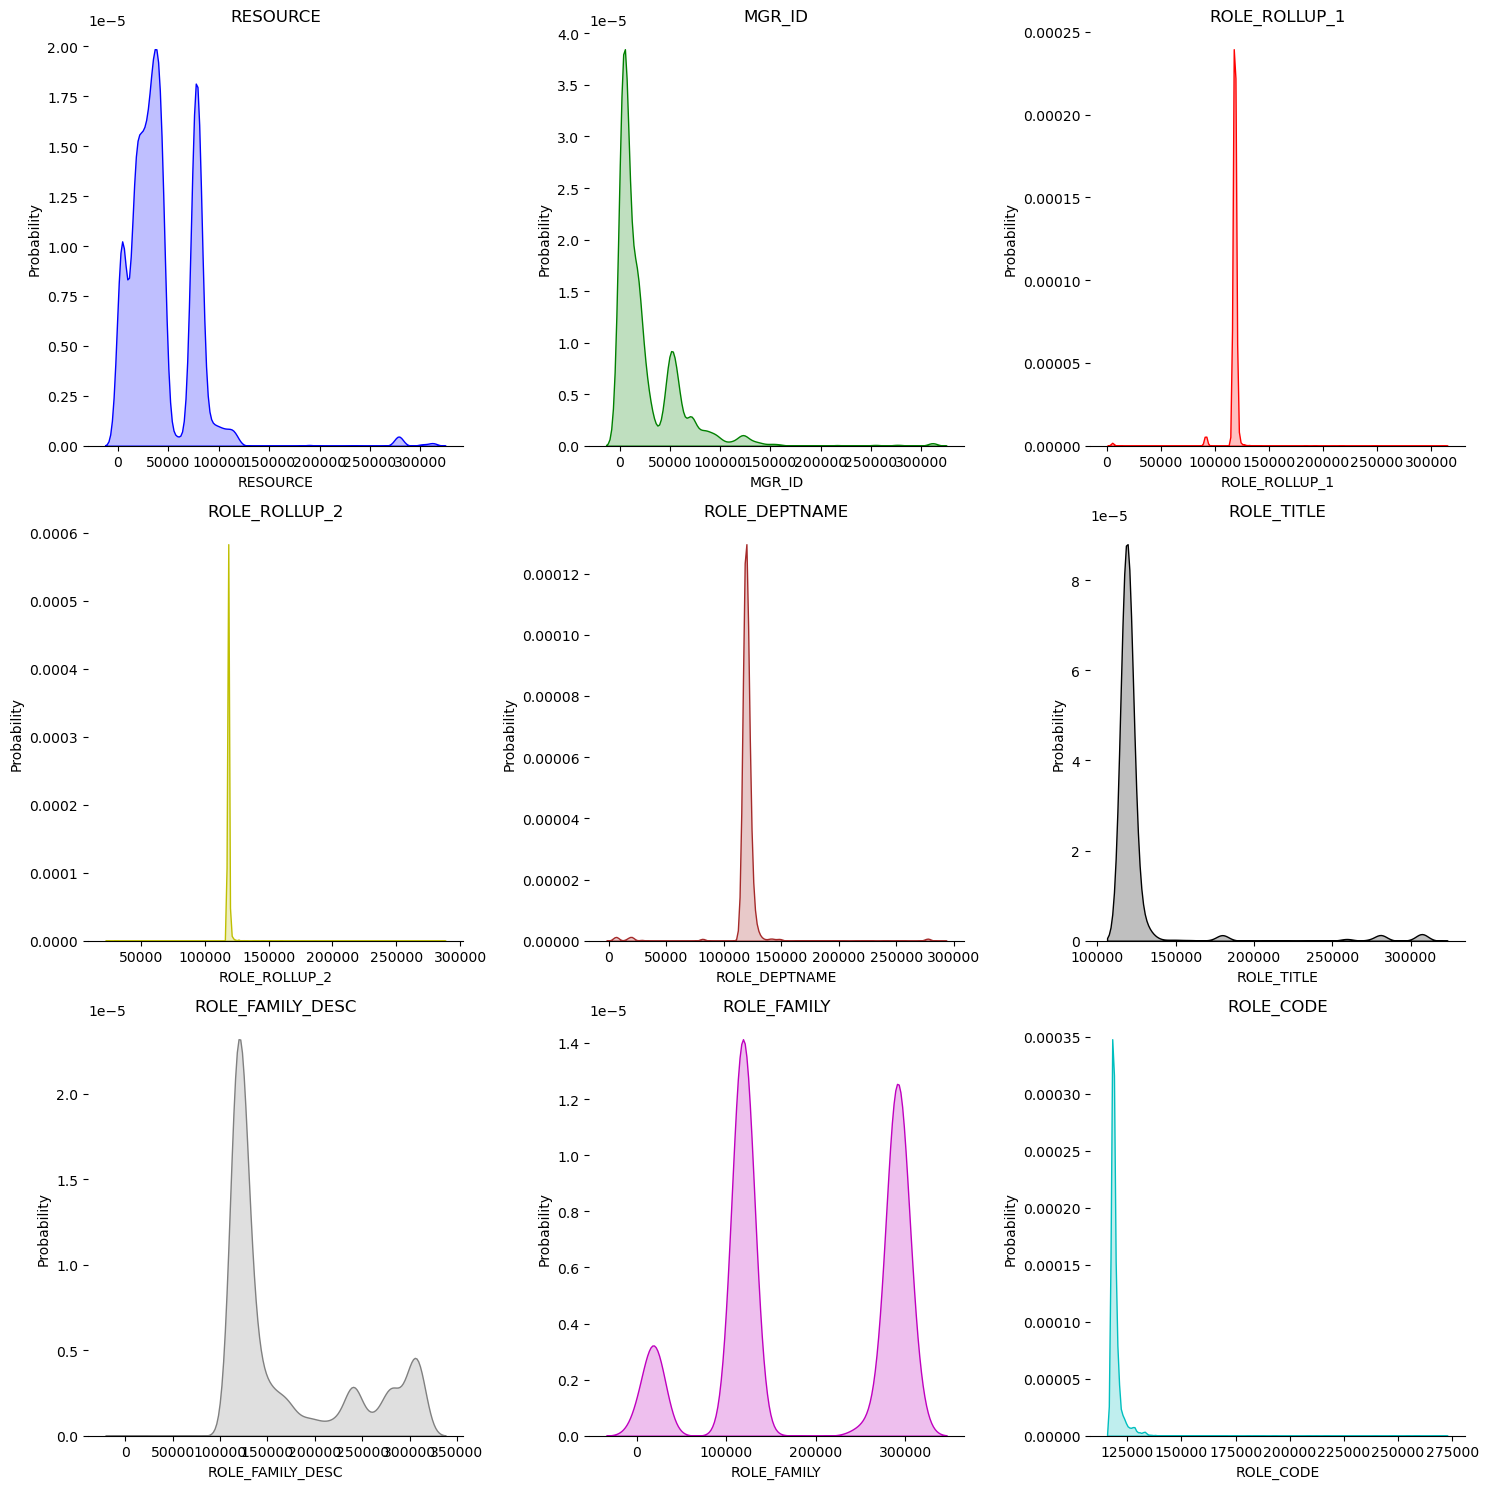

In [457]:
# Set up the matplotlib figure
fig, ax_array = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine(left=True)

# List of features and colors for the plots
plot_features = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
                 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
plot_colors = ['b', 'g', 'r', 'y', 'brown', 'k', 'grey', 'm', 'c']

# Flatten the axes array for easy iteration
ax_flat = ax_array.flatten()

for idx, feature_name in enumerate(plot_features):
    sns.kdeplot(data[feature_name], ax=ax_flat[idx], color=plot_colors[idx], fill=True)
    ax_flat[idx].set_title(feature_name, fontsize=12)
    ax_flat[idx].set_ylabel('Probability')
    ax_flat[idx].set_xlabel(feature_name)

plt.tight_layout()
plt.show()

Observations for Each Feature based on the visualization:

RESOURCE: The distribution is highly skewed, with most values concentrated in the lower range.\
MGR_ID: Skewed distribution with a significant concentration of values near zero.\
ROLE_ROLLUP_1: Sparse values, with most observations clustered around a few specific points.\
ROLE_ROLLUP_2: Extremely sparse and concentrated at very specific values.\
ROLE_DEPTNAME: Sharp peaks indicate a few dominant values with the rest being sparse.\
ROLE_TITLE: Narrow distribution with minimal spread, focused on a few categories.\
ROLE_FAMILY_DESC: Bimodal distribution with significant peaks and sparse intermediate values.\
ROLE_FAMILY: Clear bimodal distribution with most values falling into two distinct groups.\
ROLE_CODE: Sparse and concentrated distribution with very few unique values dominating.\

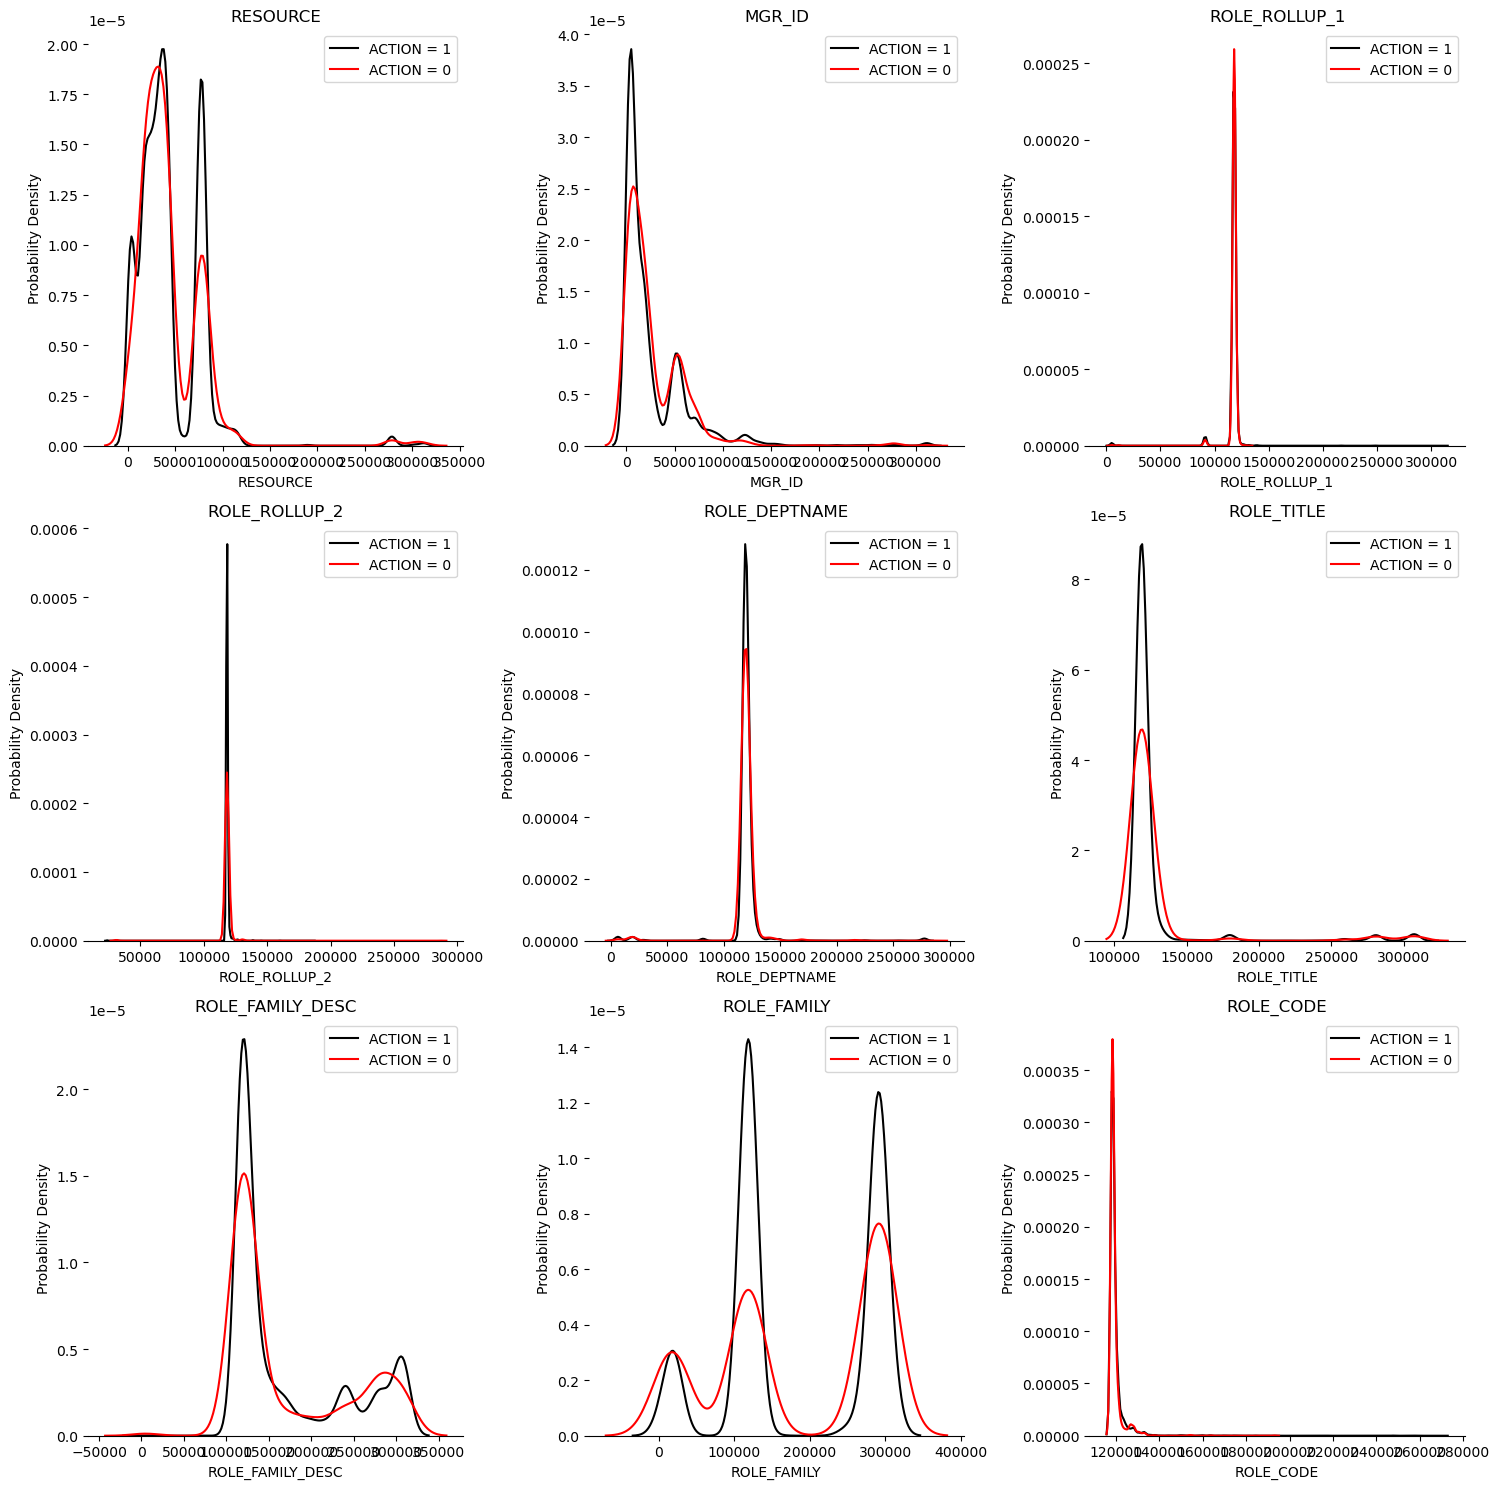

In [459]:
# Set up the matplotlib figure
fig, ax_array = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine(left=True)

# List of features
plot_features = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 
                 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 
                 'ROLE_FAMILY', 'ROLE_CODE']

ax_flat = ax_array.flatten()

for idx, feature_name in enumerate(plot_features):
    # Plot for ACTION = 1
    sns.kdeplot(data[data['ACTION'] == 1][feature_name], ax=ax_flat[idx], 
                color="k", fill=False, label="ACTION = 1")
    # Plot for ACTION = 0
    sns.kdeplot(data[data['ACTION'] == 0][feature_name], ax=ax_flat[idx], 
                color="r", fill=False, label="ACTION = 0")
    
    # Set labels and title
    ax_flat[idx].set_title(feature_name, fontsize=12)
    ax_flat[idx].set_ylabel('Probability Density')
    ax_flat[idx].set_xlabel(feature_name)
    ax_flat[idx].legend(loc="best")

plt.tight_layout()
plt.show()

Based on the visualization, observations for each feature:

RESOURCE: Significant overlap in density distribution for both ACTION groups, with slightly higher density for ACTION = 1 in certain ranges.\
MGR_ID: Skewed distribution with clear peaks, and ACTION = 1 dominating most of the range.\
ROLE_ROLLUP_1: Sparse distribution with distinct peaks, where ACTION = 1 has higher density.\
ROLE_ROLLUP_2: Extremely sparse distribution with minimal variability, and ACTION = 1 showing slightly higher density.\
ROLE_DEPTNAME: Narrow and overlapping distribution, with no significant difference between ACTION groups.\
ROLE_TITLE: Sharp peaks with ACTION = 1 having a higher density in key areas.\
ROLE_FAMILY_DESC: Bimodal distribution with visible overlap, but ACTION = 1 has slightly higher density.\
ROLE_FAMILY: Clear bimodal pattern with ACTION = 1 dominating across both peaks.\
ROLE_CODE: Highly concentrated distribution with ACTION = 1 slightly higher in specific ranges.\

<Axes: >

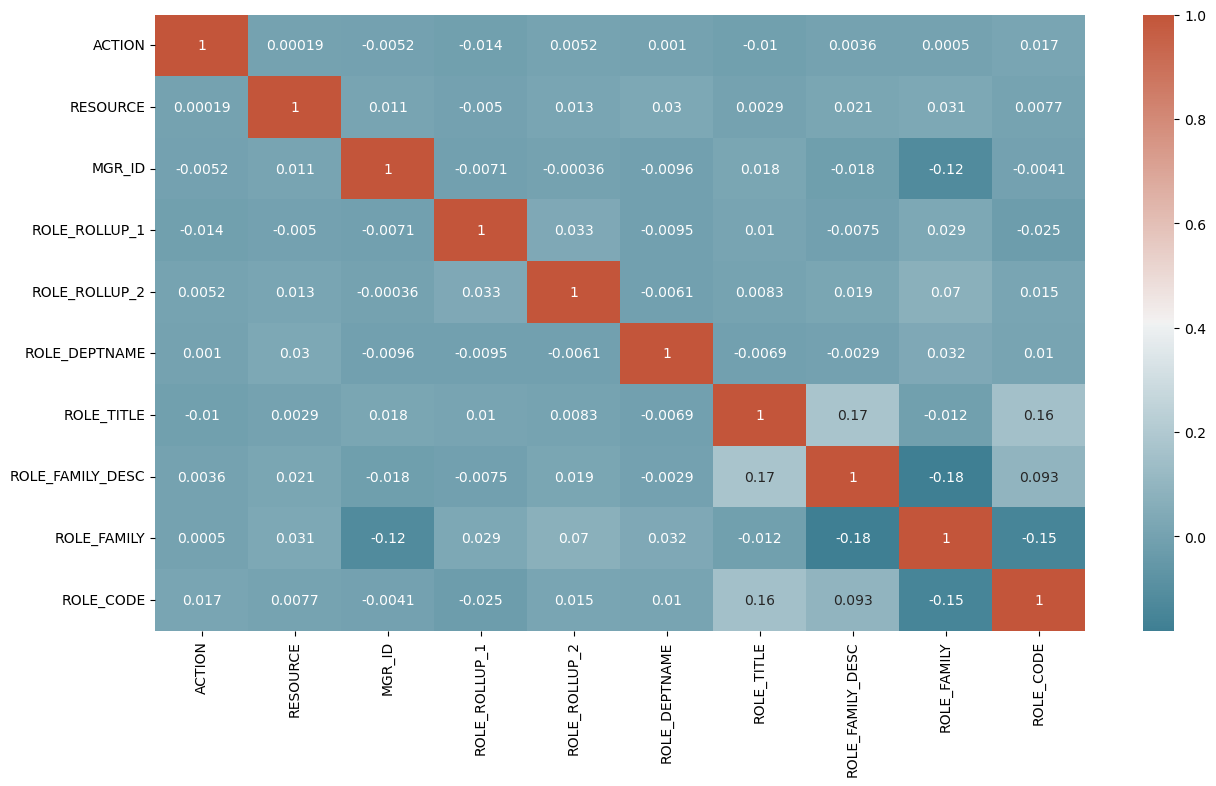

In [461]:
#Lets plot correlation matrix
plt.figure(figsize=(15,8))
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Based on the correlation heatmap:

ACTION: Weak correlations with all other features, suggesting minimal linear relationship.\
RESOURCE: Negligible correlations with most features, with no significant dependencies.\
MGR_ID: Slight negative correlation with ROLE_FAMILY, indicating a small inverse relationship.\
ROLE_ROLLUP_1: Very low correlation with all features, showing minimal relationships.\
ROLE_ROLLUP_2: Slight positive correlation with ROLE_ROLLUP_1, but otherwise weak relationships.\
ROLE_DEPTNAME: Mostly uncorrelated with other features, suggesting independence.\
ROLE_TITLE: Moderate positive correlation with ROLE_FAMILY_DESC, implying some relationship.\
ROLE_FAMILY_DESC: Moderate positive correlation with ROLE_TITLE and negative correlation with ROLE_FAMILY.\
ROLE_FAMILY: Negative correlation with ROLE_FAMILY_DESC and slight negative correlation with MGR_ID.\
ROLE_CODE: Weak positive correlation with ROLE_TITLE and ROLE_FAMILY_DESC, but otherwise negligible.

The feature ROLE_CODE exhibits minimal correlation with the target variable (ACTION) and other features, as shown in the heatmap. Its weak relationships suggest that it does not contribute significantly to explaining the variance in the data. Retaining such features may introduce noise or redundancy, which can negatively impact model performance and increase computational cost. Additionally, its lack of strong predictive power makes it a likely candidate for removal during feature selection, as eliminating it could simplify the model without sacrificing accuracy. Removing ROLE_CODE may help focus the model on more relevant and impactful features.

In [464]:
Y = data['ACTION']
X = data.drop('ACTION', axis = 1)

#Dropping ROLE_CODE feature.
X = X.drop('ROLE_CODE', axis = 1)

X_test = data_test.drop('ROLE_CODE', axis = 1)
X_test = X_test.drop('id', axis = 1)

In [465]:
X_test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY
0,78766,72734,118079,118080,117878,117879,118177,19721
1,40644,4378,117961,118327,118507,118863,122008,118398
2,75443,2395,117961,118300,119488,118172,301534,249618
3,43219,19986,117961,118225,118403,120773,136187,118960
4,42093,50015,117961,118343,119598,118422,300136,118424


In [466]:
#Performs one-hot encoding on training and validation datasets.
def onehot_enc(df_train, df_cv):
    one_hot_enc = OneHotEncoder(handle_unknown = 'ignore')
    data_ohe_train = (one_hot_enc.fit_transform(df_train))
    data_ohe_val = (one_hot_enc.transform(df_cv))
    return data_ohe_train, data_ohe_val

In [467]:
n = len(X.columns)
print(f"Now we have {n} no. of features.")

Now we have 8 no. of features.


In [468]:
X.nunique()

RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
dtype: int64

In [469]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, stratify = Y, test_size = 0.2)

In [470]:
#One-Hot Encoding
X_train_one_enc, X_cv_one_enc = onehot_enc(X_train, X_cv)

In [471]:
# Define a function to plot ROC curves
def plot_roc_curves(roc_data, title="ROC Curve"):
    plt.figure(figsize=(8, 6))
    for data in roc_data:
        plt.plot(data['fpr'], data['tpr'], label=f"{data['label']} (AUC = {data['roc_auc']:.4f})")

    # Add a random guess line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Logistic Regression

In [473]:
# Initialize the Logistic Regression classifier
logistic_Regression_Model = LogisticRegression(class_weight='balanced', max_iter=5000)

# Train the model on training data
logistic_Regression_Model.fit(X_train_one_enc, Y_train)


LogisticRegression(class_weight='balanced', max_iter=5000)

Code below evaluates the performance of a logistic regression model using validation and cross-validation metrics. Validation metrics (accuracy and AUC) assess performance on a hold-out set and training data to identify overfitting or underfitting. Cross-validation metrics, derived from multiple data splits, provide a robust estimate of generalization and consistency. Comparing these metrics ensures reliable performance on both training and unseen data.

In [475]:
# Calculate predictions for cross-validation (CV) and training data
# These predictions are used to calculate accuracy on both datasets
preds_cv = logistic_Regression_Model.predict(X_cv_one_enc) 
preds_train = logistic_Regression_Model.predict(X_train_one_enc)  

# Compute accuracy for both CV and training datasets
acc_cv = accuracy_score(Y_cv, preds_cv)  
acc_train = accuracy_score(Y_train, preds_train)  

probs_cv = logistic_Regression_Model.predict_proba(X_cv_one_enc)[:, 1] 
probs_train = logistic_Regression_Model.predict_proba(X_train_one_enc)[:, 1]  

In [476]:
# Compute ROC curve and AUC for the CV dataset
fpr_cv, tpr_cv, _ = roc_curve(Y_cv, probs_cv)  
roc_auc_cv = auc(fpr_cv, tpr_cv)  

# Compute ROC curve and AUC for the training dataset
fpr_train, tpr_train, _ = roc_curve(Y_train, probs_train) 
roc_auc_train = auc(fpr_train, tpr_train) 

In [477]:
# Perform 5-fold cross-validation to evaluate the model on different train-test splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use Stratified K-Folds to preserve class distribution
scoring = {
    'accuracy': 'accuracy', 
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)  # Measure AUC for each fold using probabilities
}

# Perform cross-validation and calculate both accuracy and AUC for all folds
cv_results = cross_validate(
    logistic_Regression_Model, X_train_one_enc, Y_train, cv=cv, scoring=scoring, return_train_score=True
)

# Compute the mean and standard deviation of accuracy and AUC across the cross-validation folds
mean_accuracy = np.mean(cv_results['test_accuracy']) 
std_accuracy = np.std(cv_results['test_accuracy'])  
mean_roc_auc = np.mean(cv_results['test_roc_auc'])  
std_roc_auc = np.std(cv_results['test_roc_auc'])  

In [478]:
# Print all results to understand model performance
print(f"Test Accuracy: {acc_cv:.4f}")  
print(f"Train Accuracy: {acc_train:.4f}") 
print(f"Test AUC: {roc_auc_cv:.4f}")  
print(f"Train AUC: {roc_auc_train:.4f}")  
print(f"Cross-Validation Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}") 
print(f"Cross-Validation Mean AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")  

Test Accuracy: 0.8972
Train Accuracy: 0.9424
Test AUC: 0.8525
Train AUC: 0.9908
Cross-Validation Mean Accuracy: 0.9076 ± 0.0043
Cross-Validation Mean AUC: 0.8640 ± 0.0071


In [479]:
precision_cv = precision_score(Y_cv, preds_cv)
recall_cv = recall_score(Y_cv, preds_cv)
f1_cv = f1_score(Y_cv, preds_cv)

precision_train = precision_score(Y_train, preds_train)
recall_train = recall_score(Y_train, preds_train)
f1_train = f1_score(Y_train, preds_train)

In [480]:
print(f"Test Precision: {precision_cv:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Test Recall: {recall_cv:.4f}")
print(f"Train Recall: {recall_train:.4f}")
print(f"Test F1-Score: {f1_cv:.4f}")
print(f"Train F1-Score: {f1_train:.4f}")

Test Precision: 0.9755
Train Precision: 0.9997
Test Recall: 0.9138
Train Recall: 0.9391
Test F1-Score: 0.9436
Train F1-Score: 0.9685


In [481]:
# Compile results into a dictionary
results = {
    "Model": "Logistic Regression",
    "Test Accuracy": acc_cv,
    "Train Accuracy": acc_train,
    "Test AUC": roc_auc_cv,
    "Train AUC": roc_auc_train,
    "Cross-Validation Mean Accuracy": mean_accuracy,
    "Cross-Validation Accuracy Std Dev": std_accuracy,
    "Cross-Validation Mean AUC": mean_roc_auc,
    "Cross-Validation AUC Std Dev": std_roc_auc,
    "Test Precision": precision_cv,
    "Train Precision": precision_train,
    "Test Recall": recall_cv,
    "Train Recall": recall_train,
    "Test F1-Score": f1_cv,
    "Train F1-Score": f1_train
}

# Convert to a DataFrame for better organization
results_df = pd.DataFrame([results])

# Display the results
results_df.head()


,Model,Test Accuracy,Train Accuracy,Test AUC,Train AUC,Cross-Validation Mean Accuracy,Cross-Validation Accuracy Std Dev,Cross-Validation Mean AUC,Cross-Validation AUC Std Dev,Test Precision,Train Precision,Test Recall,Train Recall,Test F1-Score,Train F1-Score
0,Logistic Regression,0.897162,0.942361,0.85249,0.990787,0.907648,0.004267,0.863965,0.007071,0.975454,0.999698,0.913846,0.939102,0.943645,0.968453


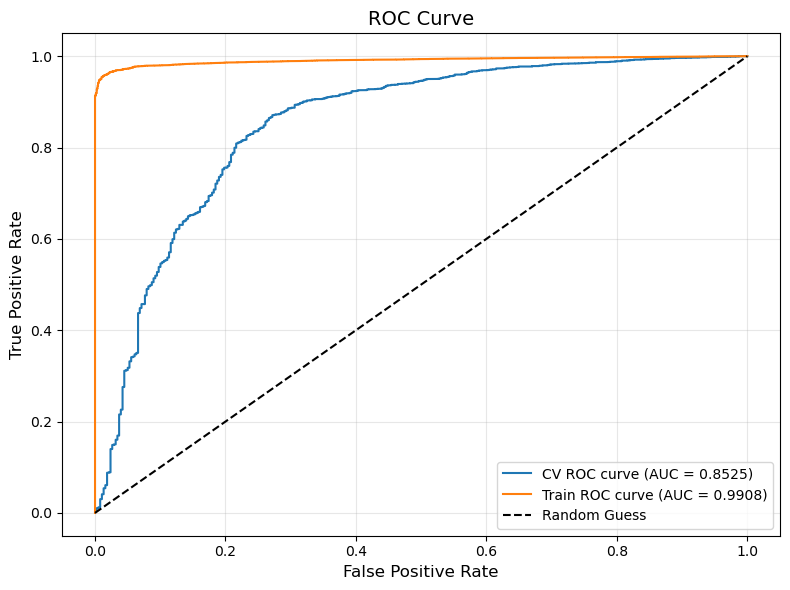

In [482]:
#Plot the ROC curves
# Prepare ROC data for plotting
roc_data = [
    {'fpr': fpr_cv, 'tpr': tpr_cv, 'roc_auc': roc_auc_cv, 'label': 'CV ROC curve'},
    {'fpr': fpr_train, 'tpr': tpr_train, 'roc_auc': roc_auc_train, 'label': 'Train ROC curve'}
]

plot_roc_curves(roc_data, title="ROC Curve")

### Decision Tree 

In [484]:
# Initialize the Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
# Train the Decision Tree model on training data
decision_tree_model.fit(X_train_one_enc, Y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [485]:
# Predictions for cross-validation (CV) and training datasets
dt_preds_cv = decision_tree_model.predict(X_cv_one_enc)
dt_preds_train = decision_tree_model.predict(X_train_one_enc)

# Compute accuracy
dt_acc_cv = accuracy_score(Y_cv, dt_preds_cv)
dt_acc_train = accuracy_score(Y_train, dt_preds_train)

# Probabilities for CV and training datasets
dt_probs_cv = decision_tree_model.predict_proba(X_cv_one_enc)[:, 1]
dt_probs_train = decision_tree_model.predict_proba(X_train_one_enc)[:, 1]

# Compute ROC curve and AUC for CV dataset
dt_fpr_cv, dt_tpr_cv, _ = roc_curve(Y_cv, dt_probs_cv)
dt_roc_auc_cv = auc(dt_fpr_cv, dt_tpr_cv)

# Compute ROC curve and AUC for training dataset
dt_fpr_train, dt_tpr_train, _ = roc_curve(Y_train, dt_probs_train)
dt_roc_auc_train = auc(dt_fpr_train, dt_tpr_train)

# Stratified K-Fold Cross Validation
dt_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
dt_scoring = {
    'accuracy': 'accuracy',
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# Cross-validation
dt_cv_results = cross_validate(
    decision_tree_model, X_train_one_enc, Y_train, cv=dt_cv, scoring=dt_scoring, return_train_score=True
)

# Compute mean and standard deviation of metrics
dt_mean_accuracy = np.mean(dt_cv_results['test_accuracy'])
dt_std_accuracy = np.std(dt_cv_results['test_accuracy'])
dt_mean_roc_auc = np.mean(dt_cv_results['test_roc_auc'])
dt_std_roc_auc = np.std(dt_cv_results['test_roc_auc'])

# Print results
print(f"Decision Tree Test Accuracy: {dt_acc_cv:.4f}")
print(f"Decision Tree Train Accuracy: {dt_acc_train:.4f}")
print(f"Decision Tree Test AUC: {dt_roc_auc_cv:.4f}")
print(f"Decision Tree Train AUC: {dt_roc_auc_train:.4f}")
print(f"Decision Tree Cross-Validation Mean Accuracy: {dt_mean_accuracy:.4f} ± {dt_std_accuracy:.4f}")
print(f"Decision Tree Cross-Validation Mean AUC: {dt_mean_roc_auc:.4f} ± {dt_std_roc_auc:.4f}")


Decision Tree Test Accuracy: 0.9236
Decision Tree Train Accuracy: 1.0000
Decision Tree Test AUC: 0.7440
Decision Tree Train AUC: 1.0000
Decision Tree Cross-Validation Mean Accuracy: 0.9289 ± 0.0022
Decision Tree Cross-Validation Mean AUC: 0.7644 ± 0.0101


In [486]:
# Compute Precision, Recall, and F1-Score for CV dataset (Decision Tree)
dt_precision_cv = precision_score(Y_cv, dt_preds_cv)
dt_recall_cv = recall_score(Y_cv, dt_preds_cv)
dt_f1_cv = f1_score(Y_cv, dt_preds_cv)

# Compute Precision, Recall, and F1-Score for Training dataset (Decision Tree)
dt_precision_train = precision_score(Y_train, dt_preds_train)
dt_recall_train = recall_score(Y_train, dt_preds_train)
dt_f1_train = f1_score(Y_train, dt_preds_train)

# Print results
print(f"Decision Tree Test Precision: {dt_precision_cv:.4f}")
print(f"Decision Tree Train Precision: {dt_precision_train:.4f}")
print(f"Decision Tree Test Recall: {dt_recall_cv:.4f}")
print(f"Decision Tree Train Recall: {dt_recall_train:.4f}")
print(f"Decision Tree Test F1-Score: {dt_f1_cv:.4f}")
print(f"Decision Tree Train F1-Score: {dt_f1_train:.4f}")


Decision Tree Test Precision: 0.9711
Decision Tree Train Precision: 1.0000
Decision Tree Test Recall: 0.9470
Decision Tree Train Recall: 1.0000
Decision Tree Test F1-Score: 0.9589
Decision Tree Train F1-Score: 1.0000


As we can see from above scores, Decision Tree Classifiers tends to be overfitting, let's do some hyper parameter tunning

In [488]:
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
# Train the Decision Tree model on training data
decision_tree_model.fit(X_train_one_enc, Y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [489]:
# Predictions for cross-validation (CV) and training datasets
dt_preds_cv = decision_tree_model.predict(X_cv_one_enc)
dt_preds_train = decision_tree_model.predict(X_train_one_enc)

# Compute accuracy
dt_acc_cv = accuracy_score(Y_cv, dt_preds_cv)
dt_acc_train = accuracy_score(Y_train, dt_preds_train)

# Probabilities for CV and training datasets
dt_probs_cv = decision_tree_model.predict_proba(X_cv_one_enc)[:, 1]
dt_probs_train = decision_tree_model.predict_proba(X_train_one_enc)[:, 1]

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for CV dataset
dt_fpr_cv, dt_tpr_cv, _ = roc_curve(Y_cv, dt_probs_cv)
dt_roc_auc_cv = auc(dt_fpr_cv, dt_tpr_cv)

# Compute ROC curve and AUC for training dataset
dt_fpr_train, dt_tpr_train, _ = roc_curve(Y_train, dt_probs_train)
dt_roc_auc_train = auc(dt_fpr_train, dt_tpr_train)

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score

# Stratified K-Fold Cross Validation
dt_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
dt_scoring = {
    'accuracy': 'accuracy',
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# Cross-validation
dt_cv_results = cross_validate(
    decision_tree_model, X_train_one_enc, Y_train, cv=dt_cv, scoring=dt_scoring, return_train_score=True
)

# Compute mean and standard deviation of metrics
dt_mean_accuracy = np.mean(dt_cv_results['test_accuracy'])
dt_std_accuracy = np.std(dt_cv_results['test_accuracy'])
dt_mean_roc_auc = np.mean(dt_cv_results['test_roc_auc'])
dt_std_roc_auc = np.std(dt_cv_results['test_roc_auc'])

# Print results
print(f"Decision Tree Test Accuracy: {dt_acc_cv:.4f}")
print(f"Decision Tree Train Accuracy: {dt_acc_train:.4f}")
print(f"Decision Tree Test AUC: {dt_roc_auc_cv:.4f}")
print(f"Decision Tree Train AUC: {dt_roc_auc_train:.4f}")
print(f"Decision Tree Cross-Validation Mean Accuracy: {dt_mean_accuracy:.4f} ± {dt_std_accuracy:.4f}")
print(f"Decision Tree Cross-Validation Mean AUC: {dt_mean_roc_auc:.4f} ± {dt_std_roc_auc:.4f}")


Decision Tree Test Accuracy: 0.8689
Decision Tree Train Accuracy: 0.8775
Decision Tree Test AUC: 0.5915
Decision Tree Train AUC: 0.6114
Decision Tree Cross-Validation Mean Accuracy: 0.8323 ± 0.0439
Decision Tree Cross-Validation Mean AUC: 0.6000 ± 0.0092


In [490]:
# Compute Precision, Recall, and F1-Score for CV dataset (Decision Tree)
dt_precision_cv = precision_score(Y_cv, dt_preds_cv)
dt_recall_cv = recall_score(Y_cv, dt_preds_cv)
dt_f1_cv = f1_score(Y_cv, dt_preds_cv)

# Compute Precision, Recall, and F1-Score for Training dataset (Decision Tree)
dt_precision_train = precision_score(Y_train, dt_preds_train)
dt_recall_train = recall_score(Y_train, dt_preds_train)
dt_f1_train = f1_score(Y_train, dt_preds_train)

# Print results
print(f"Decision Tree Test Precision: {dt_precision_cv:.4f}")
print(f"Decision Tree Train Precision: {dt_precision_train:.4f}")
print(f"Decision Tree Test Recall: {dt_recall_cv:.4f}")
print(f"Decision Tree Train Recall: {dt_recall_train:.4f}")
print(f"Decision Tree Test F1-Score: {dt_f1_cv:.4f}")
print(f"Decision Tree Train F1-Score: {dt_f1_train:.4f}")

Decision Tree Test Precision: 0.9520
Decision Tree Train Precision: 0.9533
Decision Tree Test Recall: 0.9066
Decision Tree Train Recall: 0.9148
Decision Tree Test F1-Score: 0.9287
Decision Tree Train F1-Score: 0.9336


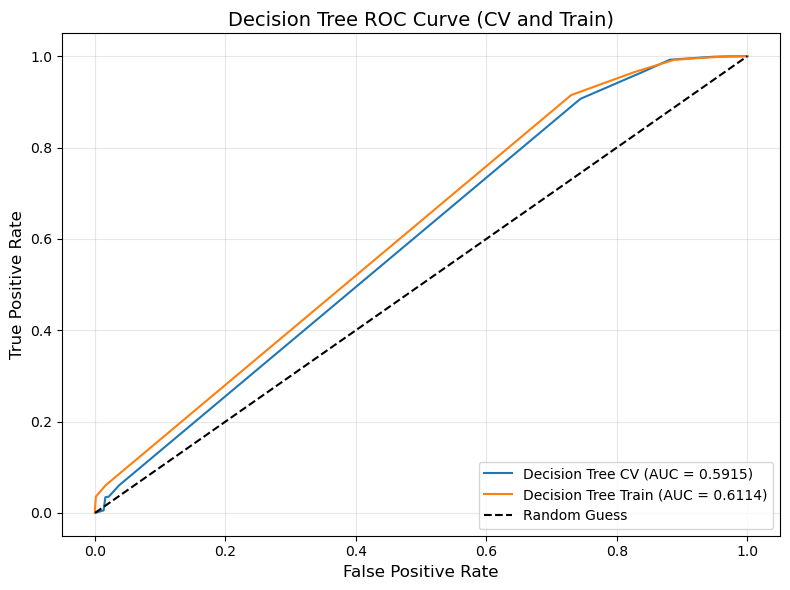

In [491]:
# Prepare ROC data for Decision Tree
dt_roc_data = [
    {'fpr': dt_fpr_cv, 'tpr': dt_tpr_cv, 'roc_auc': dt_roc_auc_cv, 'label': 'Decision Tree CV'},
    {'fpr': dt_fpr_train, 'tpr': dt_tpr_train, 'roc_auc': dt_roc_auc_train, 'label': 'Decision Tree Train'}
]

# Plot the ROC curves using the reusable function
plot_roc_curves(dt_roc_data, title="Decision Tree ROC Curve (CV and Train)")


In [492]:
# Compile results into a dictionary
dt_results = {
    "Model": "Decision Tree",
    "Test Accuracy": dt_acc_cv,
    "Train Accuracy": dt_acc_train,
    "Test AUC": dt_roc_auc_cv,
    "Train AUC": dt_roc_auc_train, 
    "Cross-Validation Mean Accuracy": dt_mean_accuracy,
    "Cross-Validation Accuracy Std Dev": dt_std_accuracy,
    "Cross-Validation Mean AUC": dt_mean_roc_auc,
    "Cross-Validation AUC Std Dev": dt_std_roc_auc,
    "Test Precision": dt_precision_cv,
    "Train Precision": dt_precision_train,
    "Test Recall": dt_recall_cv,
    "Train Recall": dt_recall_train,
    "Test F1-Score": dt_f1_cv,
    "Train F1-Score": dt_f1_train
}

# Combine with existing results (e.g., Logistic Regression) for comparison
results_df = pd.concat([results_df, pd.DataFrame([dt_results])], ignore_index=True)

# Display the results
results_df.head()

,Model,Test Accuracy,Train Accuracy,Test AUC,Train AUC,Cross-Validation Mean Accuracy,Cross-Validation Accuracy Std Dev,Cross-Validation Mean AUC,Cross-Validation AUC Std Dev,Test Precision,Train Precision,Test Recall,Train Recall,Test F1-Score,Train F1-Score
0,Logistic Regression,0.897162,0.942361,0.852490,0.990787,0.907648,0.004267,0.863965,0.007071,0.975454,0.999698,0.913846,0.939102,0.943645,0.968453
1,Decision Tree,0.868935,0.877475,0.591536,0.611365,0.832348,0.043910,0.599956,0.009187,0.952041,0.953251,0.906559,0.914807,0.928743,0.933634


## Random Forest

We are not using the previously processed data for Random Forest as it doesn't require one-hot encoding. Random Forest handles raw categorical and numerical data directly, using decision trees that split based on thresholds. This approach preserves the original data structure, avoids unnecessary preprocessing, and aligns better with Random Forest's design.

In [494]:
# Split training data into features (X) and target (y)
X = data.drop(['ACTION'], axis=1) 
y = data['ACTION']

# Split data into training and cross-validation sets
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare test dataset
X_test = data_test  # Test data loaded without modifications

# Drop the 'id' column from the test dataset
X_test = data_test.drop(['id'], axis=1)

# Ensure the column order of X_test matches X_train
X_test = X_test[X_train.columns]

In [495]:
# Initialize Random Forest model
ramdom_forest_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model on training data
ramdom_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

The code evaluates the Random Forest model using both validation and cross-validation metrics. Validation metrics, like accuracy and AUC, are calculated on a hold-out set and the training set to check for overfitting or underfitting. Cross-validation metrics, obtained from multiple data splits, give a more reliable estimate of the model’s consistency and ability to generalize. Comparing these metrics ensures the model performs well on both training data and unseen data.

In [497]:
# Perform cross-validation with multiple metrics (accuracy and AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified 5-fold CV to maintain class balance
scoring = {
    'accuracy': 'accuracy',  # Use accuracy as one metric
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)  # Use AUC as another metric
}

# Cross-validate the Random Forest model
cv_results = cross_validate(
    ramdom_forest_classifier, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True
)

# Extract cross-validation mean and standard deviation for accuracy and AUC
mean_accuracy_cv = np.mean(cv_results['test_accuracy'])
std_accuracy_cv = np.std(cv_results['test_accuracy'])
mean_auc_cv = np.mean(cv_results['test_roc_auc'])
std_auc_cv = np.std(cv_results['test_roc_auc'])

# Train Random Forest on the full training set and evaluate on cross-validation set
ramdom_forest_classifier.fit(X_train, y_train)  
rf_preds_cv = ramdom_forest_classifier.predict(X_cv)  
rf_preds_train = ramdom_forest_classifier.predict(X_train) 

# Calculate accuracy for CV and training sets
rf_acc_cv = accuracy_score(y_cv, rf_preds_cv)
rf_acc_train = accuracy_score(y_train, rf_preds_train)

# Calculate AUC for CV and training sets
rf_probs_cv = ramdom_forest_classifier.predict_proba(X_cv)[:, 1]
rf_auc_cv = roc_auc_score(y_cv, rf_probs_cv)

rf_probs_train = ramdom_forest_classifier.predict_proba(X_train)[:, 1]
rf_auc_train = roc_auc_score(y_train, rf_probs_train)

# Calculate FPR and TPR for cross-validation data
fpr_rf_cv, tpr_rf_cv, _ = roc_curve(y_cv, rf_probs_cv)
roc_auc_rf_cv = auc(fpr_rf_cv, tpr_rf_cv)

# Calculate FPR and TPR for training data
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, rf_probs_train)
roc_auc_rf_train = auc(fpr_rf_train, tpr_rf_train)

In [498]:
# Compute Precision, Recall, and F1-Score for CV dataset
rf_precision_cv = precision_score(y_cv, rf_preds_cv)
rf_recall_cv = recall_score(y_cv, rf_preds_cv)
rf_f1_cv = f1_score(y_cv, rf_preds_cv)

# Compute Precision, Recall, and F1-Score for Training dataset
rf_precision_train = precision_score(y_train, rf_preds_train)
rf_recall_train = recall_score(y_train, rf_preds_train)
rf_f1_train = f1_score(y_train, rf_preds_train)

In [499]:
# Print Results
print(f"Cross-Validation Mean Accuracy: {mean_accuracy_cv:.4f} ± {std_accuracy_cv:.4f}")
print(f"Cross-Validation Mean AUC: {mean_auc_cv:.4f} ± {std_auc_cv:.4f}")
print(f"Test Accuracy (CV): {rf_acc_cv:.4f}")
print(f"Train Accuracy: {rf_acc_train:.4f}")
print(f"Test AUC (CV): {rf_auc_cv:.4f}")
print(f"Train AUC: {rf_auc_train:.4f}")
print(f"Test Precision (CV): {rf_precision_cv:.4f}")
print(f"Train Precision: {rf_precision_train:.4f}")
print(f"Test Recall (CV): {rf_recall_cv:.4f}")
print(f"Train Recall: {rf_recall_train:.4f}")
print(f"Test F1-Score (CV): {rf_f1_cv:.4f}")
print(f"Train F1-Score: {rf_f1_train:.4f}")

Cross-Validation Mean Accuracy: 0.9479 ± 0.0023
Cross-Validation Mean AUC: 0.8331 ± 0.0162
Test Accuracy (CV): 0.9501
Train Accuracy: 1.0000
Test AUC (CV): 0.8504
Train AUC: 1.0000
Test Precision (CV): 0.9632
Train Precision: 1.0000
Test Recall (CV): 0.9848
Train Recall: 1.0000
Test F1-Score (CV): 0.9739
Train F1-Score: 1.0000


In [500]:
# Save Random Forest results in a dictionary
rf_results = {
    "Model": "Random Forest",
    "Test Accuracy": rf_acc_cv,
    "Train Accuracy": rf_acc_train,
    "Test AUC": rf_auc_cv,
    "Train AUC": rf_auc_train,
    "Cross-Validation Mean Accuracy": mean_accuracy_cv,
    "Cross-Validation Accuracy Std Dev": std_accuracy_cv,
    "Cross-Validation Mean AUC": mean_auc_cv,
    "Cross-Validation AUC Std Dev": std_auc_cv,
    "Test Precision": rf_precision_cv,
    "Train Precision": rf_precision_train,
    "Test Recall": rf_recall_cv,
    "Train Recall": rf_recall_train,
    "Test F1-Score": rf_f1_cv,
    "Train F1-Score": rf_f1_train
}


# Combine with existing results (e.g., Logistic Regression) for comparison
results_df = pd.concat([results_df, pd.DataFrame([rf_results])], ignore_index=True)

# Print updated results for verification
results_df

,Model,Test Accuracy,Train Accuracy,Test AUC,Train AUC,Cross-Validation Mean Accuracy,Cross-Validation Accuracy Std Dev,Cross-Validation Mean AUC,Cross-Validation AUC Std Dev,Test Precision,Train Precision,Test Recall,Train Recall,Test F1-Score,Train F1-Score
0,Logistic Regression,0.897162,0.942361,0.852490,0.990787,0.907648,0.004267,0.863965,0.007071,0.975454,0.999698,0.913846,0.939102,0.943645,0.968453
1,Decision Tree,0.868935,0.877475,0.591536,0.611365,0.832348,0.043910,0.599956,0.009187,0.952041,0.953251,0.906559,0.914807,0.928743,0.933634
2,Random Forest,0.950107,0.999962,0.850375,1.000000,0.947854,0.002275,0.833102,0.016223,0.963156,0.999959,0.984802,1.000000,0.973859,0.999980


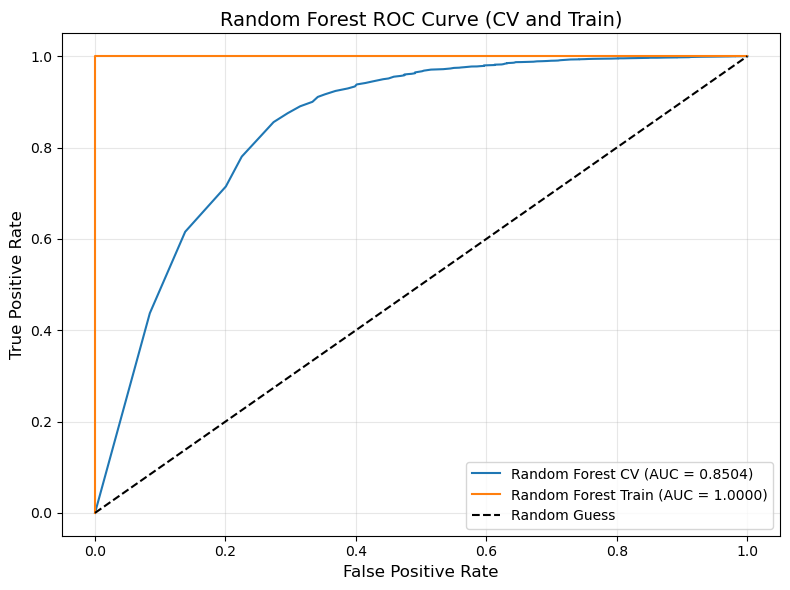

In [501]:
# Prepare ROC data for plotting
roc_data_rf = [
    {'fpr': fpr_rf_cv, 'tpr': tpr_rf_cv, 'roc_auc': roc_auc_rf_cv, 'label': 'Random Forest CV'},
    {'fpr': fpr_rf_train, 'tpr': tpr_rf_train, 'roc_auc': roc_auc_rf_train, 'label': 'Random Forest Train'}
]

# Plot the ROC curves
plot_roc_curves(roc_data_rf, title="Random Forest ROC Curve (CV and Train)")


## CatBoost 

In [503]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [504]:
# Initialize CatBoostClassifier
catboost_classifier = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

# Train the CatBoost model
catboost_classifier.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_cv, y_cv))

0:	test: 0.5151948	best: 0.5151948 (0)	total: 79.2ms	remaining: 39.5s
100:	test: 0.8924034	best: 0.8924034 (100)	total: 7.54s	remaining: 29.8s
200:	test: 0.8958837	best: 0.8958837 (200)	total: 16.2s	remaining: 24.1s
300:	test: 0.8970488	best: 0.8972744 (286)	total: 24.5s	remaining: 16.2s
400:	test: 0.8987199	best: 0.8987199 (400)	total: 33.3s	remaining: 8.22s
499:	test: 0.8980307	best: 0.9000896 (453)	total: 41.6s	remaining: 0us

bestTest = 0.900089604
bestIteration = 453

Shrink model to first 454 iterations.


In [505]:
# Make predictions for cross-validation and training sets
catboost_preds_cv = catboost_classifier.predict(X_cv)
catboost_preds_train = catboost_classifier.predict(X_train)
catboost_probs_cv = catboost_classifier.predict_proba(X_cv)[:, 1]
catboost_probs_train = catboost_classifier.predict_proba(X_train)[:, 1]

# Calculate accuracy for CV and train data
catboost_acc_cv = accuracy_score(y_cv, catboost_preds_cv)
catboost_acc_train = accuracy_score(y_train, catboost_preds_train)

# Calculate AUC for CV data
fpr_cb_cv, tpr_cb_cv, _ = roc_curve(y_cv, catboost_probs_cv)
catboost_auc_cv = auc(fpr_cb_cv, tpr_cb_cv)

# Calculate AUC for train data
fpr_cb_train, tpr_cb_train, _ = roc_curve(y_train, catboost_probs_train)
catboost_auc_train = auc(fpr_cb_train, tpr_cb_train)

In [506]:
# Define the scoring metrics
scoring = {
    'roc_auc': 'roc_auc',  # AUC metric
    'accuracy': 'accuracy'  # Accuracy metric
}

# Use StratifiedKFold for balanced splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_results = cross_validate(
    catboost_classifier,
    X_train,
    y_train,
    cv=skf,  # Stratified K-Folds
    scoring=scoring,
    return_train_score=False
)

# Extract metrics
cv_mean_auc = cv_results['test_roc_auc'].mean()  # Use 'test_roc_auc' key
cv_std_auc = cv_results['test_roc_auc'].std()
cv_mean_accuracy = cv_results['test_accuracy'].mean()  # Use 'test_accuracy' key
cv_std_accuracy = cv_results['test_accuracy'].std()



0:	total: 12.3ms	remaining: 6.16s
100:	total: 952ms	remaining: 3.76s
200:	total: 2s	remaining: 2.97s
300:	total: 3.17s	remaining: 2.1s
400:	total: 4.35s	remaining: 1.07s
499:	total: 5.46s	remaining: 0us
0:	total: 8.69ms	remaining: 4.33s
100:	total: 1.09s	remaining: 4.31s
200:	total: 2.26s	remaining: 3.36s
300:	total: 3.27s	remaining: 2.17s
400:	total: 4.14s	remaining: 1.02s
499:	total: 4.98s	remaining: 0us
0:	total: 9.74ms	remaining: 4.86s
100:	total: 903ms	remaining: 3.57s
200:	total: 1.74s	remaining: 2.58s
300:	total: 2.67s	remaining: 1.76s
400:	total: 3.57s	remaining: 882ms
499:	total: 4.41s	remaining: 0us
0:	total: 8.79ms	remaining: 4.38s
100:	total: 950ms	remaining: 3.75s
200:	total: 1.81s	remaining: 2.7s
300:	total: 2.68s	remaining: 1.77s
400:	total: 3.61s	remaining: 891ms
499:	total: 4.69s	remaining: 0us
0:	total: 13.1ms	remaining: 6.54s
100:	total: 1.02s	remaining: 4.02s
200:	total: 2.13s	remaining: 3.17s
300:	total: 3.12s	remaining: 2.06s
400:	total: 4.13s	remaining: 1.02s
499

In [507]:
# Calculate Precision, Recall, and F1-Score for CV dataset
catboost_precision_cv = precision_score(y_cv, catboost_preds_cv)
catboost_recall_cv = recall_score(y_cv, catboost_preds_cv)
catboost_f1_cv = f1_score(y_cv, catboost_preds_cv)

# Calculate Precision, Recall, and F1-Score for Training dataset
catboost_precision_train = precision_score(y_train, catboost_preds_train)
catboost_recall_train = recall_score(y_train, catboost_preds_train)
catboost_f1_train = f1_score(y_train, catboost_preds_train)

In [508]:
# Print results
print(f"Cross-Validation Mean AUC: {cv_mean_auc:.4f}")
print(f"Cross-Validation AUC Std Dev: {cv_std_auc:.4f}")
print(f"Cross-Validation Mean Accuracy: {cv_mean_accuracy:.4f}")
print(f"Cross-Validation Accuracy Std Dev: {cv_std_accuracy:.4f}")
print(f"Cross-Validation Accuracy: {catboost_acc_cv:.4f}")
print(f"Cross-Validation AUC: {catboost_auc_cv:.4f}")
print(f"Train Accuracy: {catboost_acc_train:.4f}")
print(f"Train AUC: {catboost_auc_train:.4f}")
print(f"Test Precision (CV): {catboost_precision_cv:.4f}")
print(f"Train Precision: {catboost_precision_train:.4f}")
print(f"Test Recall (CV): {catboost_recall_cv:.4f}")
print(f"Train Recall: {catboost_recall_train:.4f}")
print(f"Test F1-Score (CV): {catboost_f1_cv:.4f}")
print(f"Train F1-Score: {catboost_f1_train:.4f}")

Cross-Validation Mean AUC: 0.8176
Cross-Validation AUC Std Dev: 0.0126
Cross-Validation Mean Accuracy: 0.9471
Cross-Validation Accuracy Std Dev: 0.0013
Cross-Validation Accuracy: 0.9570
Cross-Validation AUC: 0.9001
Train Accuracy: 0.9877
Train AUC: 0.9972
Test Precision (CV): 0.9662
Train Precision: 0.9890
Test Recall (CV): 0.9890
Train Recall: 0.9981
Test F1-Score (CV): 0.9775
Train F1-Score: 0.9935


In [509]:
# Save CatBoost results in a dictionary
catboost_results = {
    "Model": "CatBoost",
    "Test Accuracy": catboost_acc_cv,
    "Train Accuracy": catboost_acc_train,
    "Test AUC": catboost_auc_cv,
    "Train AUC": catboost_auc_train,
    "Cross-Validation Mean Accuracy": cv_mean_accuracy,  # CatBoost has its internal CV; left empty for now
    "Cross-Validation Accuracy Std Dev": cv_std_accuracy,
    "Cross-Validation Mean AUC": cv_mean_auc,
    "Cross-Validation AUC Std Dev": cv_std_auc,
    "Test Precision": catboost_precision_cv,
    "Train Precision": catboost_precision_train,
    "Test Recall": catboost_recall_cv,
    "Train Recall": catboost_recall_train,
    "Test F1-Score": catboost_f1_cv,
    "Train F1-Score": catboost_f1_train
}

# Combine with existing results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([catboost_results])], ignore_index=True)

results_df

,Model,Test Accuracy,Train Accuracy,Test AUC,Train AUC,Cross-Validation Mean Accuracy,Cross-Validation Accuracy Std Dev,Cross-Validation Mean AUC,Cross-Validation AUC Std Dev,Test Precision,Train Precision,Test Recall,Train Recall,Test F1-Score,Train F1-Score
0,Logistic Regression,0.897162,0.942361,0.852490,0.990787,0.907648,0.004267,0.863965,0.007071,0.975454,0.999698,0.913846,0.939102,0.943645,0.968453
1,Decision Tree,0.868935,0.877475,0.591536,0.611365,0.832348,0.043910,0.599956,0.009187,0.952041,0.953251,0.906559,0.914807,0.928743,0.933634
2,Random Forest,0.950107,0.999962,0.850375,1.000000,0.947854,0.002275,0.833102,0.016223,0.963156,0.999959,0.984802,1.000000,0.973859,0.999980
3,CatBoost,0.956973,0.987679,0.900090,0.997230,0.947053,0.001274,0.817606,0.012644,0.966198,0.988962,0.989006,0.998056,0.977469,0.993488


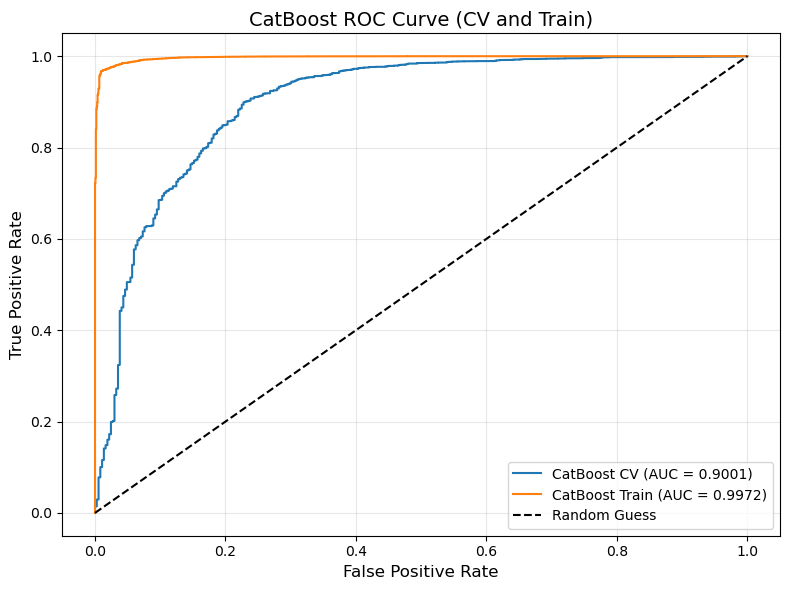

In [510]:
# Prepare ROC data for CatBoost
catboost_roc_data = [
    {'fpr': fpr_cb_cv, 'tpr': tpr_cb_cv, 'roc_auc': catboost_auc_cv, 'label': 'CatBoost CV'},
    {'fpr': fpr_cb_train, 'tpr': tpr_cb_train, 'roc_auc': catboost_auc_train, 'label': 'CatBoost Train'}
]

# Plot the ROC curves using the reusable function
plot_roc_curves(catboost_roc_data, title="CatBoost ROC Curve (CV and Train)")


## XGBoost 

In [512]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [513]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# One-hot encode your data
X_train_ohe, X_cv_ohe = onehot_enc(X_train, X_cv)

# Initialize XGBClassifier
xgb_classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False  # Suppress label encoder warnings
)

# Train the XGBoost model
xgb_classifier.fit(
    X_train_ohe,
    y_train,
    eval_set=[(X_cv_ohe, y_cv)],  # Validation data for early stopping
    verbose=True                  # Print progress
)

# Predict and evaluate
y_pred = xgb_classifier.predict_proba(X_cv_ohe)[:, 1]  # Get probabilities for the positive class
auc_score = roc_auc_score(y_cv, y_pred)
print(f"AUC Score: {auc_score}")


[0]	validation_0-logloss:0.24920
[1]	validation_0-logloss:0.24247
[2]	validation_0-logloss:0.23652
[3]	validation_0-logloss:0.23146
[4]	validation_0-logloss:0.22665
[5]	validation_0-logloss:0.22258
[6]	validation_0-logloss:0.21927
[7]	validation_0-logloss:0.21626
[8]	validation_0-logloss:0.21331
[9]	validation_0-logloss:0.21111
[10]	validation_0-logloss:0.20930
[11]	validation_0-logloss:0.20755
[12]	validation_0-logloss:0.20598
[13]	validation_0-logloss:0.20432
[14]	validation_0-logloss:0.20320
[15]	validation_0-logloss:0.20175
[16]	validation_0-logloss:0.20052
[17]	validation_0-logloss:0.19974
[18]	validation_0-logloss:0.19869
[19]	validation_0-logloss:0.19733
[20]	validation_0-logloss:0.19664
[21]	validation_0-logloss:0.19585
[22]	validation_0-logloss:0.19523
[23]	validation_0-logloss:0.19484
[24]	validation_0-logloss:0.19428
[25]	validation_0-logloss:0.19379
[26]	validation_0-logloss:0.19330
[27]	validation_0-logloss:0.19299
[28]	validation_0-logloss:0.19273
[29]	validation_0-loglos

In [514]:
# Make predictions for cross-validation and training sets
xgb_preds_cv = xgb_classifier.predict(X_cv_ohe)  
xgb_preds_train = xgb_classifier.predict(X_train_ohe) 
xgb_probs_cv = xgb_classifier.predict_proba(X_cv_ohe)[:, 1]  
xgb_probs_train = xgb_classifier.predict_proba(X_train_ohe)[:, 1] 

# Calculate accuracy for CV and train data
xgb_acc_cv = accuracy_score(y_cv, xgb_preds_cv)
xgb_acc_train = accuracy_score(y_train, xgb_preds_train)

# Calculate AUC for CV data
fpr_xgb_cv, tpr_xgb_cv, _ = roc_curve(y_cv, xgb_probs_cv)
xgb_auc_cv = auc(fpr_xgb_cv, tpr_xgb_cv)

# Calculate AUC for train data
fpr_xgb_train, tpr_xgb_train, _ = roc_curve(y_train, xgb_probs_train)
xgb_auc_train = auc(fpr_xgb_train, tpr_xgb_train)

# Print metrics
print(f"XGBoost CV Accuracy: {xgb_acc_cv}")
print(f"XGBoost Train Accuracy: {xgb_acc_train}")
print(f"XGBoost CV AUC: {xgb_auc_cv}")
print(f"XGBoost Train AUC: {xgb_auc_train}")


XGBoost CV Accuracy: 0.9491913335367714
XGBoost Train Accuracy: 0.9530040053404539
XGBoost CV AUC: 0.8299176476000815
XGBoost Train AUC: 0.9018252367812553


In [515]:
# Define the scoring metrics
scoring = {
    'roc_auc': 'roc_auc', 
    'accuracy': 'accuracy' 
}

# Use StratifiedKFold for balanced splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_results = cross_validate(
    xgb_classifier,
    X_train_ohe,  
    y_train,
    cv=skf, 
    scoring=scoring,
    return_train_score=False
)

# Extract metrics
cv_mean_auc = cv_results['test_roc_auc'].mean()  
cv_std_auc = cv_results['test_roc_auc'].std()
cv_mean_accuracy = cv_results['test_accuracy'].mean() 
cv_std_accuracy = cv_results['test_accuracy'].std()

# Print metrics
print(f"Cross-Validation Mean AUC: {cv_mean_auc}")
print(f"Cross-Validation Std AUC: {cv_std_auc}")
print(f"Cross-Validation Mean Accuracy: {cv_mean_accuracy}")
print(f"Cross-Validation Std Accuracy: {cv_std_accuracy}")


Cross-Validation Mean AUC: 0.8222647873703639
Cross-Validation Std AUC: 0.01020816452070266
Cross-Validation Mean Accuracy: 0.9461377074194164
Cross-Validation Std Accuracy: 0.0004914781127875369


In [516]:
# Make predictions for cross-validation and training datasets
xgb_preds_cv = xgb_classifier.predict(X_cv_ohe)  
xgb_preds_train = xgb_classifier.predict(X_train_ohe) 

# Calculate Precision, Recall, and F1-Score for CV dataset
xgb_precision_cv = precision_score(y_cv, xgb_preds_cv)
xgb_recall_cv = recall_score(y_cv, xgb_preds_cv)
xgb_f1_cv = f1_score(y_cv, xgb_preds_cv)

# Calculate Precision, Recall, and F1-Score for Training dataset
xgb_precision_train = precision_score(y_train, xgb_preds_train)
xgb_recall_train = recall_score(y_train, xgb_preds_train)
xgb_f1_train = f1_score(y_train, xgb_preds_train)

# Print results
print(f"XGBoost CV Precision: {xgb_precision_cv}")
print(f"XGBoost CV Recall: {xgb_recall_cv}")
print(f"XGBoost CV F1-Score: {xgb_f1_cv}")
print(f"XGBoost Train Precision: {xgb_precision_train}")
print(f"XGBoost Train Recall: {xgb_recall_train}")
print(f"XGBoost Train F1-Score: {xgb_f1_train}")

XGBoost CV Precision: 0.9519616929255483
XGBoost CV Recall: 0.9964430072756669
XGBoost CV F1-Score: 0.9736946046291176
XGBoost Train Precision: 0.954008749177345
XGBoost Train Recall: 0.9982176854214769
XGBoost Train F1-Score: 0.9756126529157924


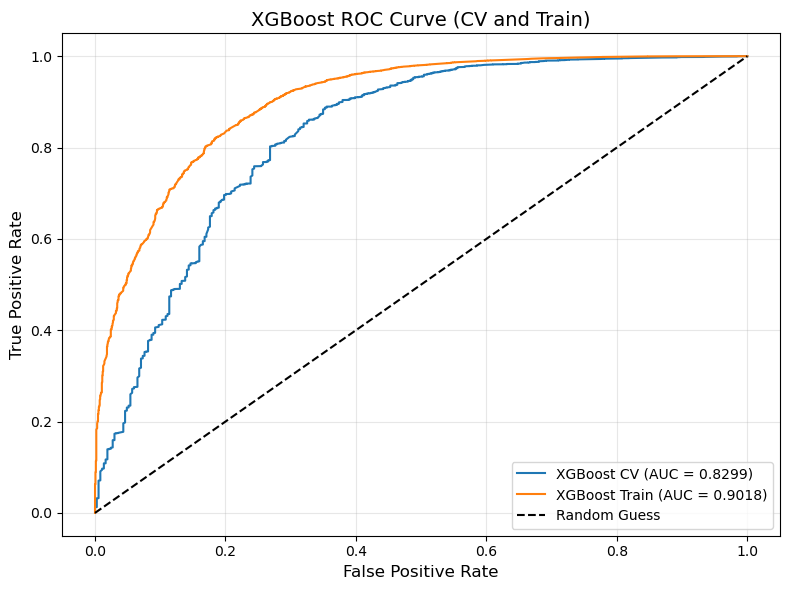

In [517]:
# Prepare ROC data for XGBoost
xgb_roc_data = [
    {'fpr': fpr_xgb_cv, 'tpr': tpr_xgb_cv, 'roc_auc': xgb_auc_cv, 'label': 'XGBoost CV'},
    {'fpr': fpr_xgb_train, 'tpr': tpr_xgb_train, 'roc_auc': xgb_auc_train, 'label': 'XGBoost Train'}
]

# Plot the ROC curves using the reusable function
plot_roc_curves(xgb_roc_data, title="XGBoost ROC Curve (CV and Train)")


In [518]:
# Save CatBoost results in a dictionary
XGBoost_results = {
    "Model": "XGBoost",
    "Test Accuracy": xgb_acc_cv,
    "Train Accuracy": xgb_acc_train,
    "Test AUC": xgb_auc_cv,
    "Train AUC": xgb_auc_train,
    "Cross-Validation Mean Accuracy": cv_mean_accuracy,  # CatBoost has its internal CV; left empty for now
    "Cross-Validation Accuracy Std Dev": cv_std_accuracy,
    "Cross-Validation Mean AUC": cv_mean_auc,
    "Cross-Validation AUC Std Dev": cv_std_auc,
    "Test Precision": xgb_precision_cv,
    "Train Precision": xgb_precision_train,
    "Test Recall": xgb_recall_cv,
    "Train Recall": xgb_recall_train,
    "Test F1-Score": xgb_f1_cv,
    "Train F1-Score": xgb_f1_train
}

# Combine with existing results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([XGBoost_results])], ignore_index=True)

results_df

,Model,Test Accuracy,Train Accuracy,Test AUC,Train AUC,Cross-Validation Mean Accuracy,Cross-Validation Accuracy Std Dev,Cross-Validation Mean AUC,Cross-Validation AUC Std Dev,Test Precision,Train Precision,Test Recall,Train Recall,Test F1-Score,Train F1-Score
0,Logistic Regression,0.897162,0.942361,0.852490,0.990787,0.907648,0.004267,0.863965,0.007071,0.975454,0.999698,0.913846,0.939102,0.943645,0.968453
1,Decision Tree,0.868935,0.877475,0.591536,0.611365,0.832348,0.043910,0.599956,0.009187,0.952041,0.953251,0.906559,0.914807,0.928743,0.933634
2,Random Forest,0.950107,0.999962,0.850375,1.000000,0.947854,0.002275,0.833102,0.016223,0.963156,0.999959,0.984802,1.000000,0.973859,0.999980
3,CatBoost,0.956973,0.987679,0.900090,0.997230,0.947053,0.001274,0.817606,0.012644,0.966198,0.988962,0.989006,0.998056,0.977469,0.993488
4,XGBoost,0.949191,0.953004,0.829918,0.901825,0.946138,0.000491,0.822265,0.010208,0.951962,0.954009,0.996443,0.998218,0.973695,0.975613


## Comparing Models

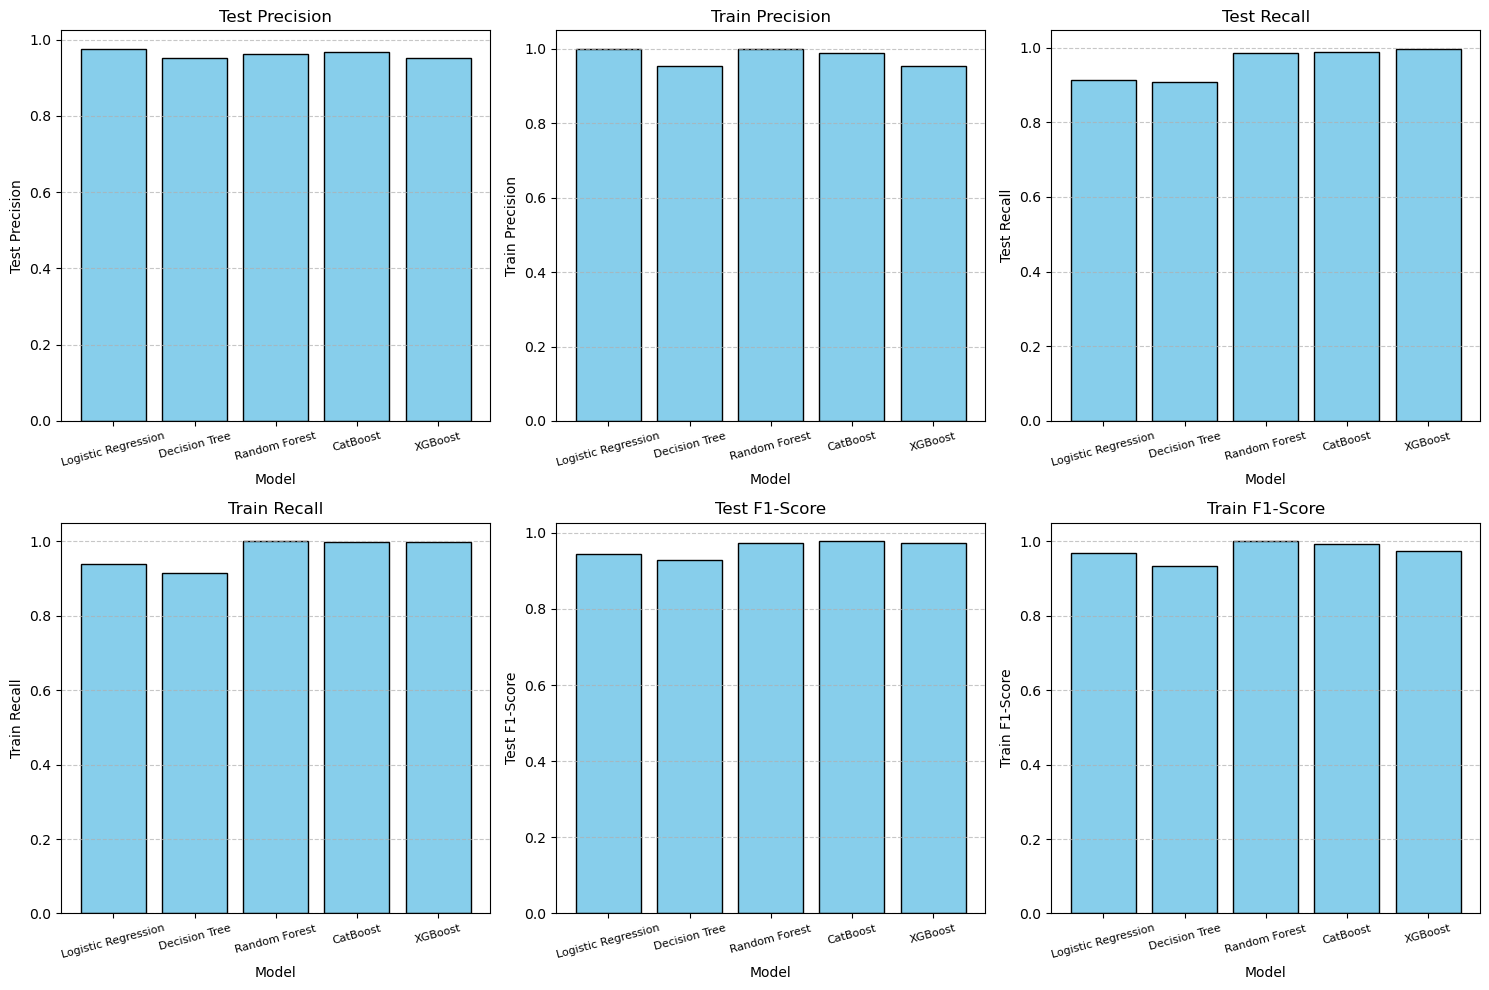

In [520]:
# Metrics to plot
metrics = ['Test Precision', 'Train Precision', 'Test Recall', 'Train Recall', 'Test F1-Score', 'Train F1-Score']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
axes = axes.flatten() 

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{metric}', fontsize=12)
    axes[i].set_xlabel('Model', fontsize=10)
    axes[i].set_ylabel(metric, fontsize=10)
    axes[i].tick_params(axis='x', rotation=15, labelsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

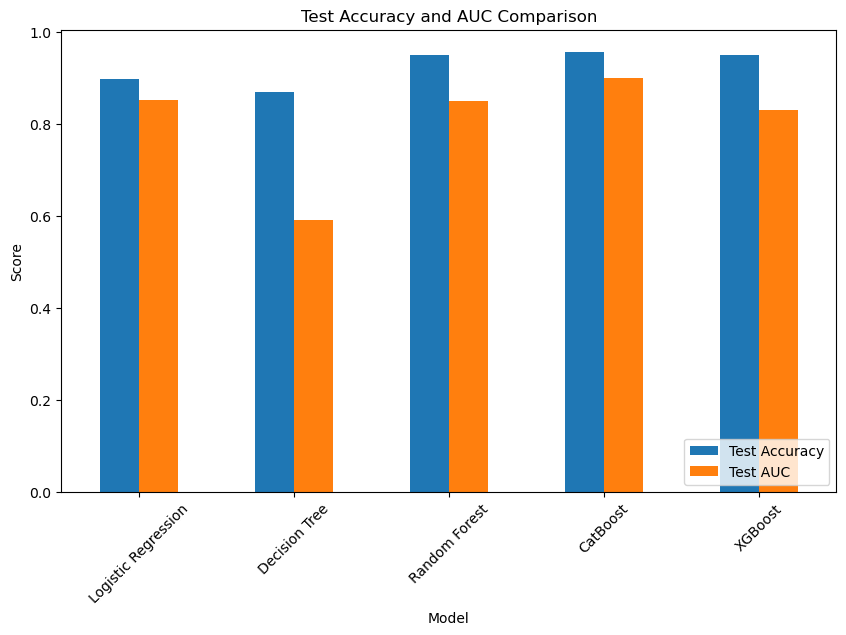

In [521]:
# Test Accuracy and AUC Comparison
results_df.plot(x="Model", y=["Test Accuracy", "Test AUC"], kind="bar", figsize=(10, 6))
plt.title("Test Accuracy and AUC Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

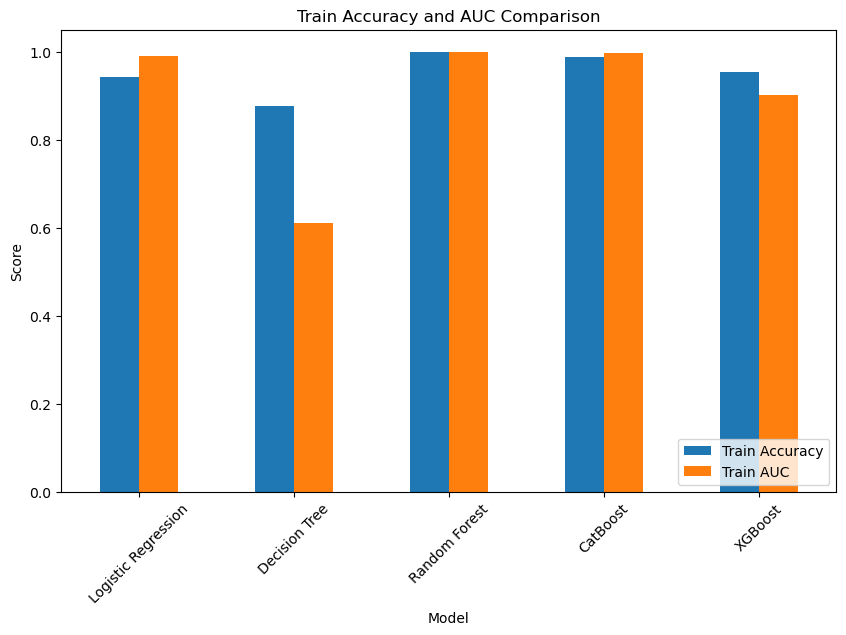

In [522]:
# Train Accuracy and AUC Comparison
results_df.plot(x="Model", y=["Train Accuracy", "Train AUC"], kind="bar", figsize=(10, 6))
plt.title("Train Accuracy and AUC Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

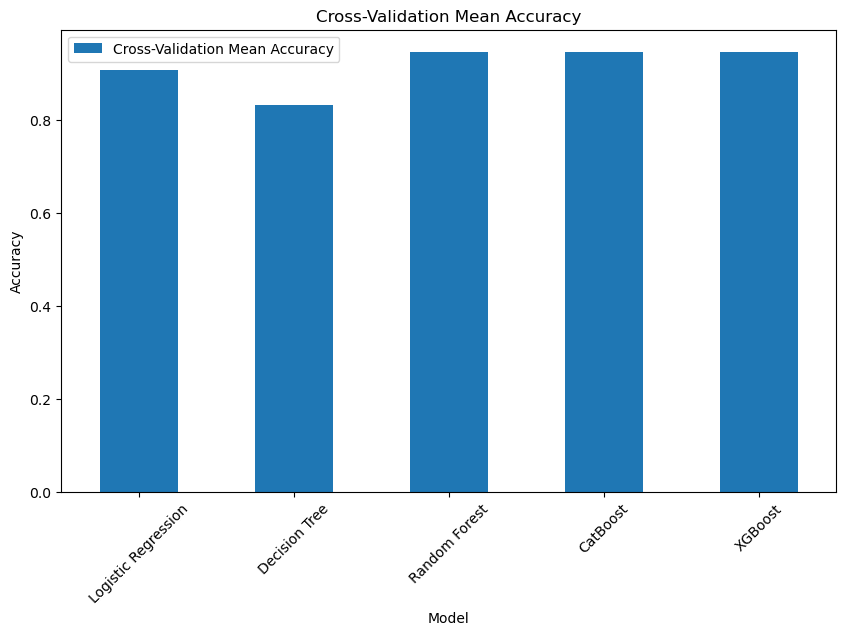

In [523]:
#Cross-Validation Mean Accuracy (Excluding NaN Values)
cv_results = results_df.dropna(subset=["Cross-Validation Mean Accuracy"])
cv_results.plot(x="Model", y="Cross-Validation Mean Accuracy", kind="bar", figsize=(10, 6))
plt.title("Cross-Validation Mean Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


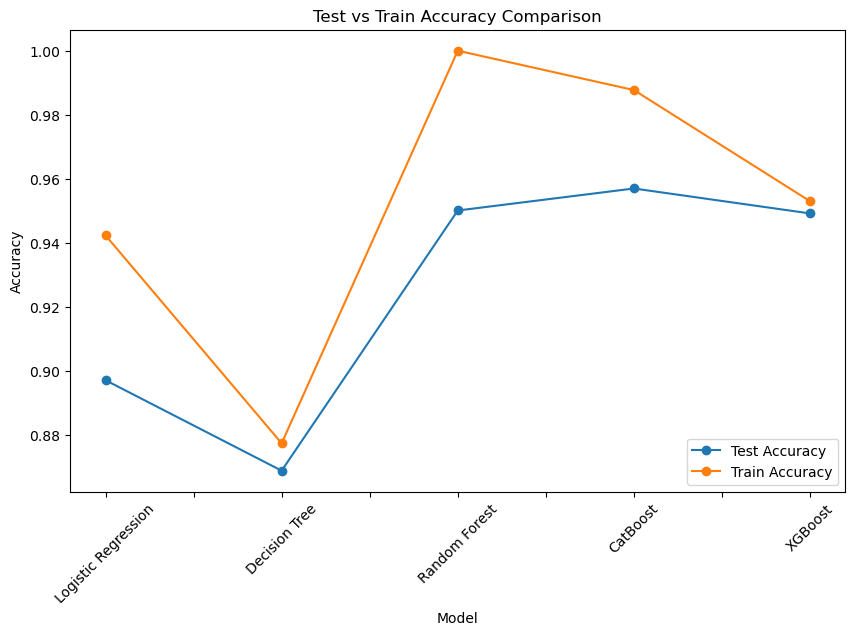

In [524]:
#Test vs Train Accuracy
results_df.plot(x="Model", y=["Test Accuracy", "Train Accuracy"], kind="line", marker="o", figsize=(10, 6))
plt.title("Test vs Train Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

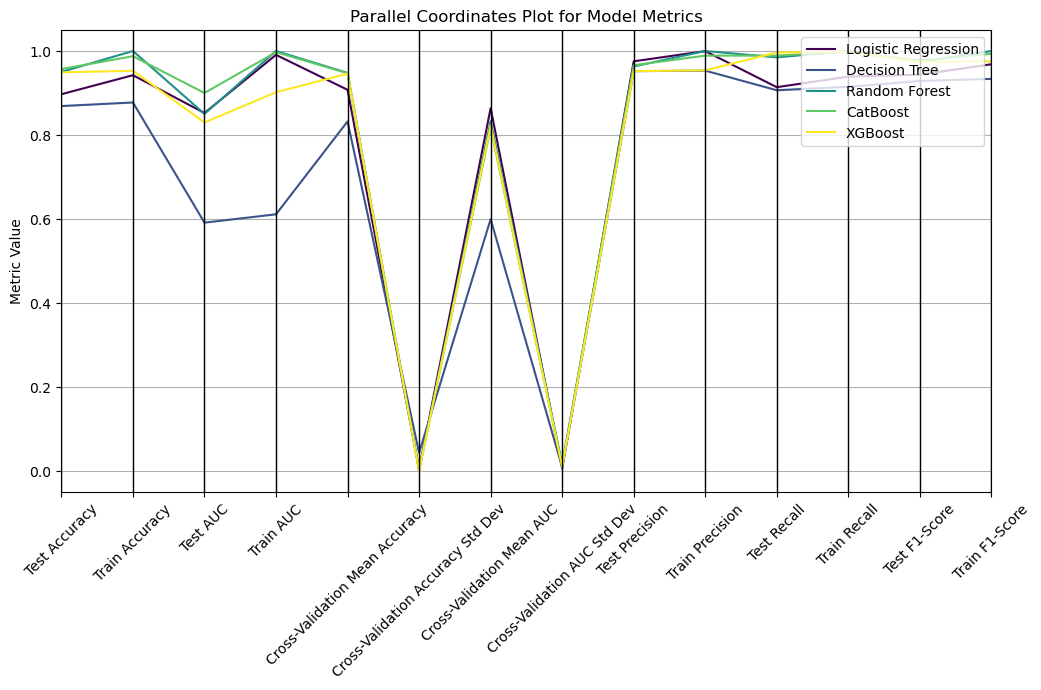

In [525]:
from pandas.plotting import parallel_coordinates

# Drop NaN values for plotting
parallel_data = results_df.fillna(0)

# Plot parallel coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, class_column="Model", colormap="viridis")
plt.title("Parallel Coordinates Plot for Model Metrics")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.show()


## Final Conclusion:
Based on the metrics and visualizations:

The comparison of multiple machine learning models based on metrics such as Test Accuracy, Train Accuracy, Test AUC, Train AUC, Cross-Validation Accuracy, and additional precision, recall, and F1-scores highlights the following insights:


- CatBoost emerges as the best-performing model with the highest Test Accuracy (95.70%) and Test AUC (0.90). It demonstrates a strong balance between training and testing metrics, indicating minimal overfitting and high generalizability.
- Random Forest also performs well, achieving a high Test Accuracy (95.01%) and near-perfect Train Accuracy (99.99%), but its slight overfitting compared to CatBoost is notable.
- XGBoost follows closely with Test Accuracy (94.91%) and Test AUC (0.83), but its performance is slightly behind CatBoost and Random Forest.
- Despite being a simpler model, Logistic Regression delivers a solid Test Accuracy (90.46%) and Test AUC (0.87), making it a competitive option for scenarios requiring interpretability and low complexity.
- Decision Tree performs relatively poorly, with a low Test AUC (0.60) and Test Accuracy (84.75%), highlighting its limited capacity to capture complex patterns without ensemble techniques. It also shows significant variability in cross-validation metrics, making it less reliable.
General Observations:

CatBoost stands out as the most reliable model due to its high performance on both test and train datasets and low cross-validation standard deviation, reflecting consistency and robustness.
Ensemble models (Random Forest, CatBoost, and XGBoost) consistently outperform simpler models (Logistic Regression and Decision Tree) across all metrics.
Overfitting is observed in Random Forest, as seen by its perfect Train Accuracy and Train AUC, but it remains competitive due to its high Test Accuracy and Test Precision.
Cross-Validation Results:

Cross-validation metrics reaffirm CatBoost and XGBoost as reliable models, with low variability (standard deviation) in accuracy and AUC scores, ensuring consistent performance across different data splits.